# Importing Libraries


In [1]:
import numpy as np
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator, load_img


In [2]:
from tensorflow.keras.utils import to_categorical

In [3]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os

In [4]:
print(os.listdir(r"C:\Users\parth\ML Workshop"))

['.ipynb_checkpoints', 'dogs-vs-cats.zip', 'Minor Project 2.ipynb', 'Minor_Project-1(PARTHA DE).ipynb', 'salary_data.csv', 'sampleSubmission.csv', 'test1', 'test1.zip', 'train', 'train.zip']


In [5]:
FAST_RUN = False
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

# Prepare Training Data

In [56]:
filenames = os.listdir(r"C:\Users\parth\ML Workshop\train")
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [7]:
df.head()

,filename,category
0,cat.0.jpg,0
1,cat.1.jpg,0
2,cat.10.jpg,0
3,cat.100.jpg,0
4,cat.1000.jpg,0


In [57]:
df.tail()


,filename,category
24995,dog.9995.jpg,1
24996,dog.9996.jpg,1
24997,dog.9997.jpg,1
24998,dog.9998.jpg,1
24999,dog.9999.jpg,1


<AxesSubplot:>

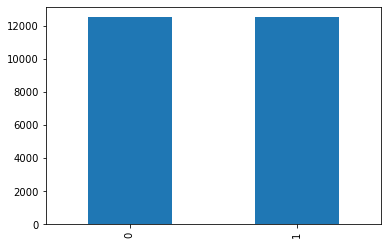

In [58]:
df['category'].value_counts().plot.bar()

# Sample Image

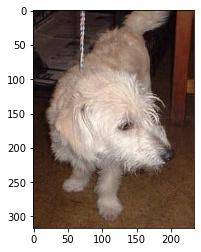

In [60]:
sample = random.choice(filenames)
image = load_img("train/"+sample)
plt.imshow(image)

# Building Model

In [10]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

In [11]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

In [12]:
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

In [13]:

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

In [14]:
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

In [15]:
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 126, 126, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 61, 61, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)        0

In [16]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [17]:
earlystop = EarlyStopping(patience=10)

In [18]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc',patience=2,verbose=1,factor=0.5,min_lr=0.00001)

In [19]:
callbacks = [earlystop, learning_rate_reduction]

In [20]:
df["category"] = df["category"].replace({0: 'cat', 1: 'dog'}) 

In [21]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

<AxesSubplot:>

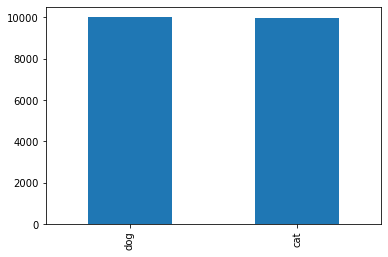

In [22]:
train_df['category'].value_counts().plot.bar()

<AxesSubplot:>

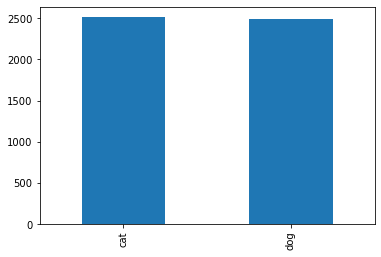

In [23]:
validate_df['category'].value_counts().plot.bar()

In [24]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=15

# Training


In [25]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)



In [26]:
train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    r"C:\Users\parth\ML Workshop\train", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 20000 validated image filenames belonging to 2 classes.


In [27]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    r"C:\Users\parth\ML Workshop\train", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 5000 validated image filenames belonging to 2 classes.


In [28]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    r"C:\Users\parth\ML Workshop\train", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical'
)

Found 1 validated image filenames belonging to 1 classes.


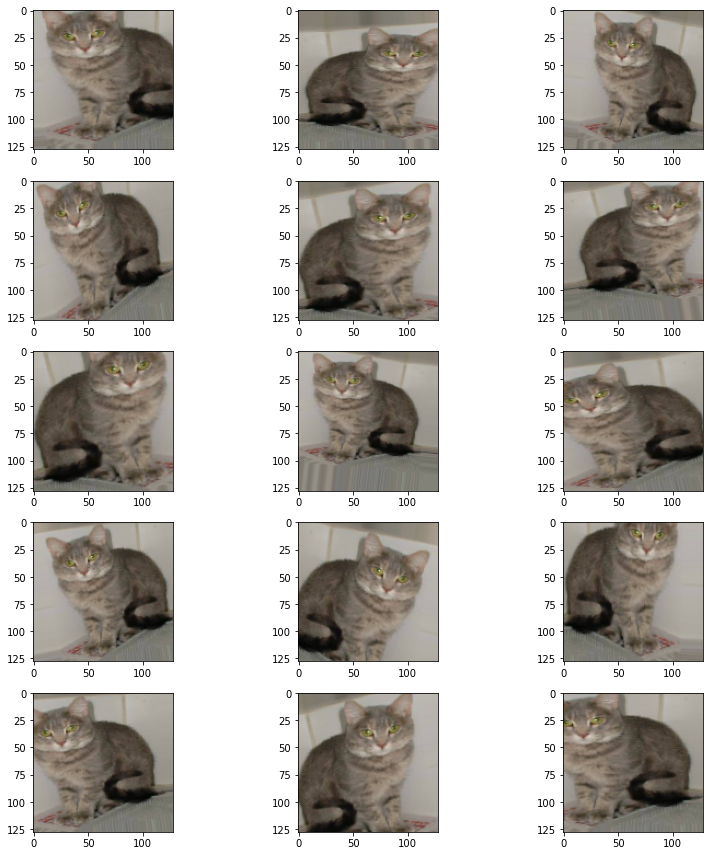

In [29]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

# Fit Model

In [30]:
epochs=3 if FAST_RUN else 25
history = model.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

C:\ProgramData\Anaconda3\lib\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/25
1333/1333 [==============================] - 493s 368ms/step - loss: 0.7398 - accuracy: 0.6370 - val_loss: 0.5719 - val_accuracy: 0.6999
Epoch 2/25
1333/1333 [==============================] - 476s 357ms/step - loss: 0.5514 - accuracy: 0.7248 - val_loss: 0.5513 - val_accuracy: 0.7335
Epoch 3/25
1333/1333 [==============================] - 433s 325ms/step - loss: 0.5000 - accuracy: 0.7610 - val_loss: 0.4515 - val_accuracy: 0.7952
Epoch 4/25
1333/1333 [==============================] - 429s 322ms/step - loss: 0.4595 - accuracy: 0.7897 - val_loss: 0.5162 - val_accuracy: 0.7493
Epoch 5/25
1333/1333 [==============================] - 491s 369ms/step - loss: 0.4300 - accuracy: 0.8036 - val_loss: 0.4212 - val_accuracy: 0.7926
Epoch 6/25
1333/1333 [==============================] - 437s 328ms/step - loss: 0.4104 - accuracy: 0.8199 - val_loss: 0.4110 - val_accuracy: 0.8128
Epoch 7/25
1333/1333 [==============================] - 437s 328ms/step - loss: 0.4002 - accuracy: 0.8233 - val_

In [32]:
model.save_weights("model.h5")

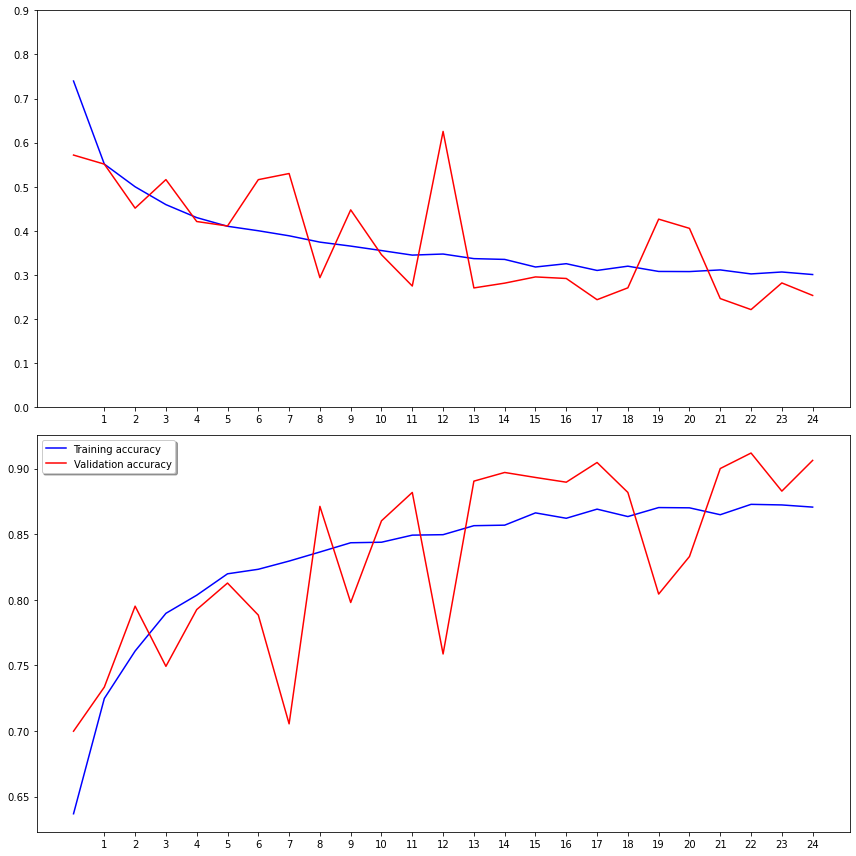

In [62]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

In [35]:
test_filenames = os.listdir(r"C:\Users\parth\ML Workshop\train")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

In [37]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    r"C:\Users\parth\ML Workshop\train", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)

Found 25000 validated image filenames.


In [39]:
predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))

In [40]:
test_df['category'] = np.argmax(predict, axis=-1)

In [41]:
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)

In [42]:
test_df['category'] = test_df['category'].replace({ 'dog': 1, 'cat': 0 })

<AxesSubplot:>

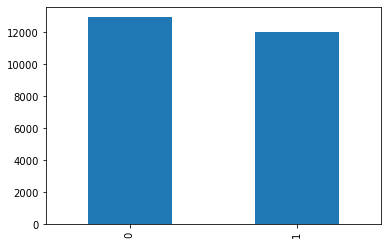

In [43]:
test_df['category'].value_counts().plot.bar()

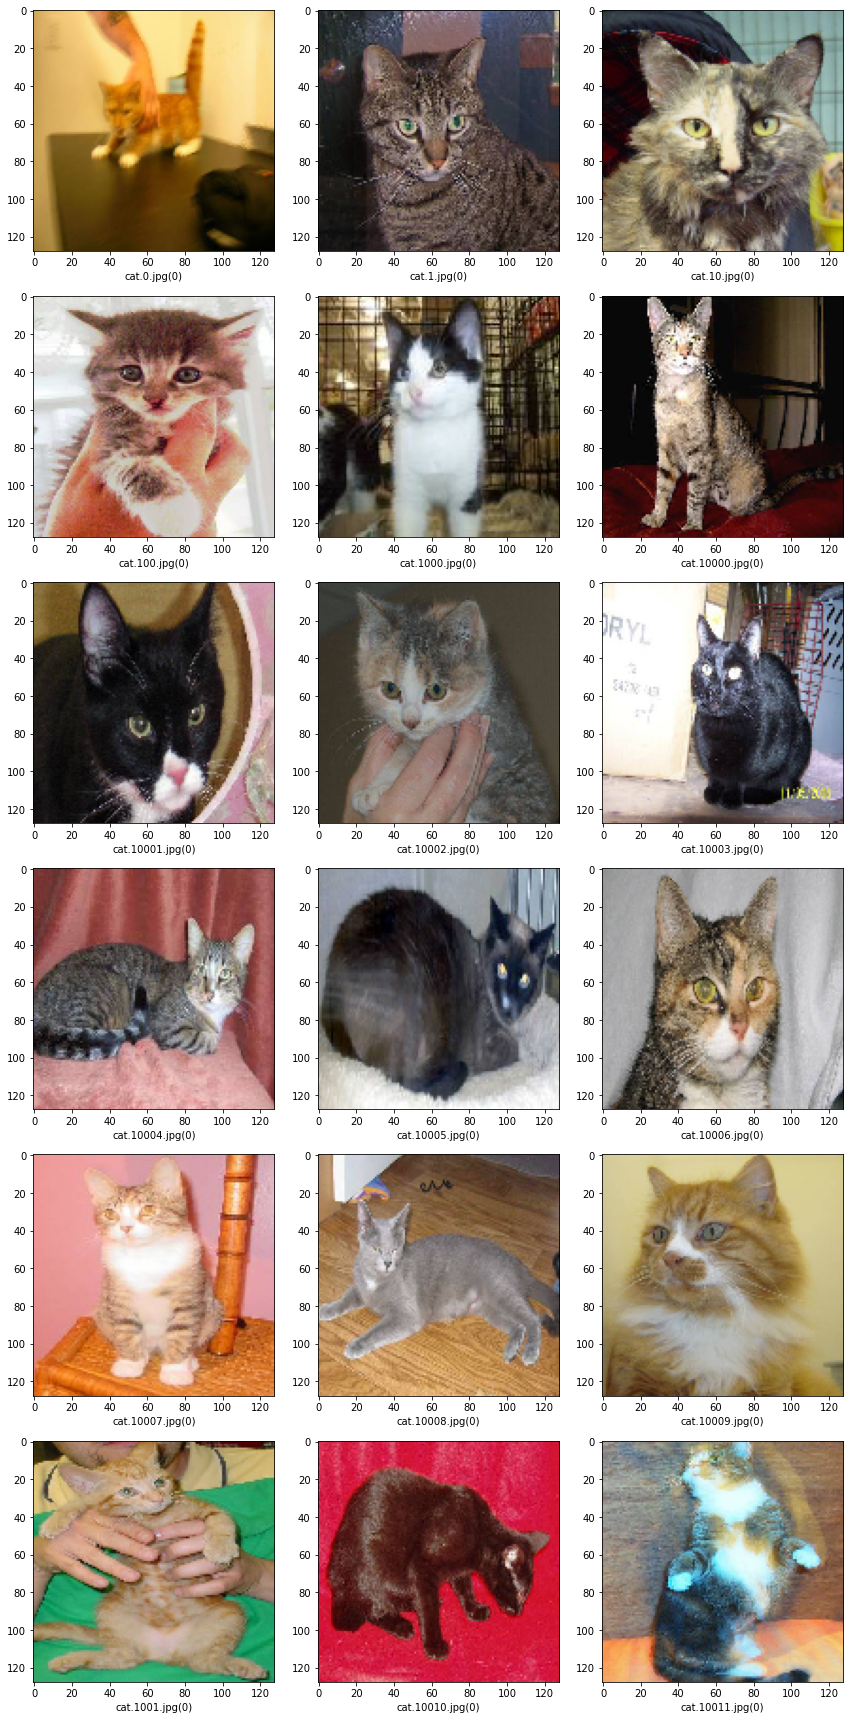

In [61]:
sample_test = test_df.head(18)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img("train/"+filename, target_size=IMAGE_SIZE)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()

In [54]:
submission_df = test_df.copy()
submission_df['id'] = submission_df['filename'].str.split('.').str[0]
submission_df['label'] = submission_df['category']
submission_df.drop(['filename', 'category'], axis=1, inplace=True)
submission_df.to_csv('submission.csv', index=False)